In [1]:
# !pip install sklearn
# !pip install efficientnet_pytorch
# !pip install scikit-image
# !pip install albumentations
import numpy as np
import pandas as pd
from PIL import Image, ImageFile , ImageCms
ImageFile.LOAD_TRUNCATED_IMAGES = True
import sys
import os
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as imshow
import cv2
from collections import Counter
from random import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import  WeightedRandomSampler

import albumentations
from albumentations.pytorch import ToTensorV2

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from torchvision import models
import torchvision.transforms as transforms
from efficientnet_pytorch import EfficientNet

import pickle
import copy
import random
import warnings
warnings.filterwarnings('ignore')
print(torch.__version__)
print(torch.version.cuda)

print('-----loaded libraries-----')

1.8.1
10.2
-----loaded libraries-----


In [2]:
random.seed(42)
# Paths
model_name = 'resnet18'
image_path = './data/images/'
gt_path = './data/ground_truth/'
model_path = './models/'+model_name+'.pkl'
output_path = './output/'+model_name+'.csv'

In [3]:
# Model parameters
image_size = 512
batch_size = 32
pre_trained = True 
epochs = 10
lr = 1e-5
weight_decay = 0.000001
patience = 10
, num_workers = 10

In [4]:
train_transforms = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightness(limit=0.2, p=0.75),
    albumentations.RandomContrast(limit=0.2, p=0.75),
    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=5),
        albumentations.MedianBlur(blur_limit=5),
        albumentations.GaussianBlur(blur_limit=5),
        albumentations.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),

    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.0),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
        albumentations.ElasticTransform(alpha=3),
    ], p=0.7),
    albumentations.CLAHE(clip_limit=4.0, p=0.7),
    albumentations.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
    albumentations.Resize(image_size, image_size),
    albumentations.Cutout(max_h_size=int(image_size * 0.375), max_w_size=int(image_size * 0.375), num_holes=1, p=0.7),
    albumentations.Normalize(),
    ToTensorV2()
])

valid_transforms = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize(),
    ToTensorV2()
])

In [5]:
class MelanomaDataset(Dataset):
    def __init__(self, gt_df, image_path, transforms = None , image_size = 512):
        self.image_path = image_path
        self.gt = gt_df.target
        self.image_names = gt_df.image_name
        self.transforms = transforms
                
    def __len__(self):
        return len(self.image_names)
    
    def _transform(self, image):
        transform = albumentations.Compose([albumentations.Resize((image_size, image_size)),
                                        albumentations.Normalize(),
                                        ToTensorV2()
                                       ])    
    def __getitem__(self, index):
        image_name = self.image_names[index]
        target = self.gt[index]
        image = cv2.imread(self.image_path+image_name+'.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if transforms is not None:
            image = self.transforms(image=image)["image"]
        else:
            image = self._transform(image=image)["image"]
        return image, target

In [6]:
# train_gt_df = pd.read_csv(gt_path + 'train.csv')
# train_image_folder = image_path + 'train/'
# train_dataset = MelanomaDataset(train_gt_df, train_image_folder)

In [7]:
train_gt_df = pd.read_csv(gt_path + 'train.csv')
train_image_path = image_path + 'train/'
train_idx, valid_idx = train_test_split(np.arange(len(train_gt_df.target)), test_size = 0.2, shuffle = True, stratify=train_gt_df.target)
train_gt_df['split'] = 'valid'
train_gt_df['split'].loc[train_idx] = 'train'
train_df = train_gt_df.loc[train_gt_df['split'] == 'train']
valid_df = train_gt_df.loc[train_gt_df['split'] == 'valid']
# train_df =  train_df.head(1000)
# valid_df =  valid_df.head(1000)
train_df = train_df.reset_index()
valid_df = valid_df.reset_index()
train_dataset = MelanomaDataset(gt_df = train_df, image_path = train_image_path, transforms = train_transforms, image_size = image_size)
valid_dataset = MelanomaDataset(gt_df = valid_df, image_path = train_image_path, transforms =  valid_transforms, image_size = image_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The class for ISIC_0080752 is: 0
-----verified dataset-----


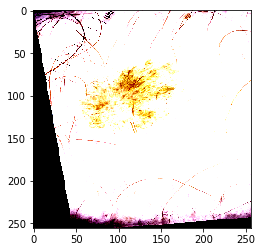

In [8]:
idx = 16
b = np.rollaxis(train_dataset[idx][0].numpy(),0,3)
print('The class for ' + train_dataset.image_names[idx] +' is: ' + str(train_dataset[idx][1]))
plt.imshow(b)
print('-----verified dataset-----')

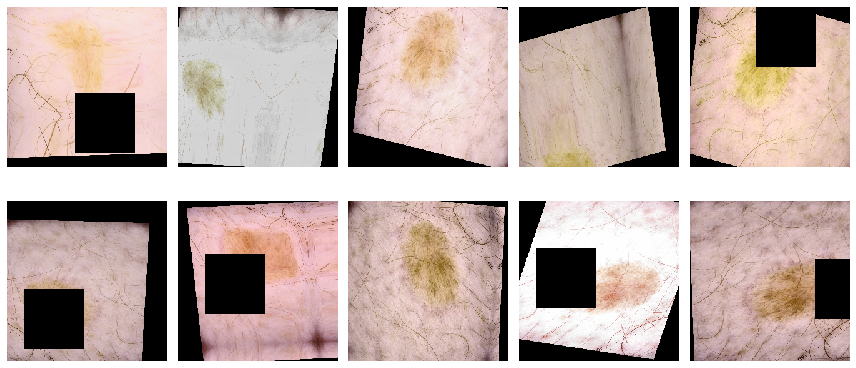

-----visualised augmentations-----


In [9]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transforms = albumentations.Compose([t for t in dataset.transforms if not isinstance(t, (albumentations.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()  

visualize_augmentations(train_dataset,idx=idx)
print('-----visualised augmentations-----')

In [10]:
# train_idx, valid_idx = train_test_split(np.arange(len(train_dataset.gt)), test_size = 0.2, shuffle = True, stratify=train_dataset.gt)
# train_idx = train_idx[0:999]
# valid_idx = valid_idx[0:999]
# train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
# valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
# print('-----split datasets-----')

In [11]:
def compute_weights(dataset):
    counts = sorted(Counter(dataset.gt).items())
    class_sample_counts = [x[1] for x in counts]
    weights = 1. / torch.tensor(class_sample_counts, dtype=torch.float)
    samples_weights = weights[dataset.gt.tolist()]
    return weights,samples_weights

weights,samples_weights = compute_weights(train_dataset)
print(sorted(Counter(train_dataset.gt).items()))
print(weights)

weighted_sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,sampler = weighted_sampler, num_workers = num_workers, pin_memory = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = batch_size, num_workers = num_workers, pin_memory = True)
data_loaders = {'train': train_loader, 'val': valid_loader}
print('-----created dataloaders-----')

[(0, 26033), (1, 467)]
tensor([3.8413e-05, 2.1413e-03])
-----created dataloaders-----


In [12]:
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
# valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
# data_loaders = {'train': train_loader, 'val': valid_loader}
# print('-----created dataloaders-----')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----visualised batch-----
tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
        1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1])
-----batch labels-----


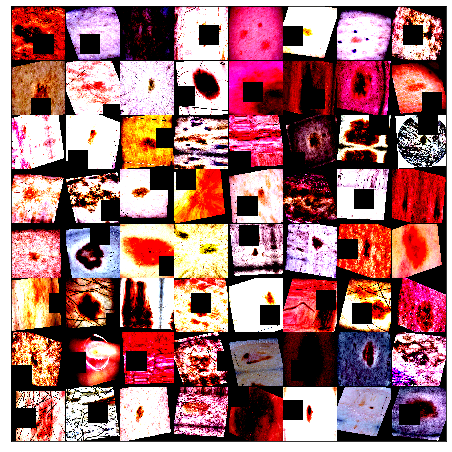

In [13]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break
show_batch(data_loaders['train'])
print('-----visualised batch-----')
print(next(iter(data_loaders['train']))[1])
print('-----batch labels-----')

In [14]:
# # RESNET
# model = models.resnet18(pretrained = pre_trained, progress = False)
# fc_in_features = model.fc.in_features
# model.fc = nn.Linear(fc_in_features,1)
# total_params = sum(p.numel() for p in model.parameters())
# print('number of paramaters: '+str(total_params))
# print('-----created model-----')

number of paramaters: 11177025
-----created model-----


In [15]:
#Efficient NET
model = EfficientNet.from_pretrained('efficientnet-b3')
fc_in_features = model._fc.in_features
model._fc = nn.Linear(fc_in_features,1)
total_params = sum(p.numel() for p in model.parameters())
print('number of paramaters: '+str(total_params))
print('-----created model-----')

In [16]:
# DEFINE THE DEVICE
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count()>1:
    print('Number of GPUs: '+ str(torch.cuda.device_count()))
    model = nn.DataParallel(model)
model = model.to(device)
print('-----Attached GPU-----')  

-----Attached GPU-----


In [17]:
# DEFINE A FUNCTION TO TRAIN THE MODEL
def train_model(model, dataloaders, criterion, optimizer, lr_scheduler, model_path, output_path, num_epochs=25):
    since = time.time()

    val_auc_history = []
    val_loss_history = []
    train_auc_history = []
    train_loss_history = []

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))

    best_model_wts = copy.deepcopy(model.state_dict())
    best_auc = 0.0
    for epoch in range(1, num_epochs+1):
        
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_targets = []
            # Iterate over data.
            for inputs, targets in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                targets = targets.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, targets.unsqueeze(1).float())
                    # Get model predictions
                    _, preds = torch.max(outputs, 1) 
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == targets.data)
                all_preds.append(preds)
                all_targets.append(targets)
            epoch_loss = running_loss / len(dataloaders[phase].sampler)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler)
            all_targets = torch.cat(all_targets, 0)
            all_preds = torch.cat(all_preds, 0)
            print(sum(all_targets))
            print(sum(all_preds))
            epoch_auc = roc_auc_score(all_targets.cpu().numpy(),all_preds.cpu().numpy())
            if phase == 'val':
                lr_scheduler.step(epoch_loss)
            if epoch == 1 and phase == 'train':
                df = pd.DataFrame({'epoch': epoch,'phase':phase, 'epoch_loss':epoch_loss,'epoch_acc':epoch_acc.cpu().numpy(),'epoch_auc':epoch_auc}, index=[0])
                df.to_csv(output_path,mode = 'a',header=True)
                print('-----wrote first output-----')
            else:
                df = pd.DataFrame({'epoch': epoch,'phase':phase, 'epoch_loss':epoch_loss,'epoch_acc':epoch_acc.cpu().numpy(),'epoch_auc':epoch_auc}, index=[0])
                df.to_csv(output_path,mode = 'a',header=False)

            print('{} Loss: {:.4f} - Acc: {:.4f} - AUC: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_auc))

            # deep copy the model
            if phase == 'val' and epoch_auc > best_auc:
                best_auc = epoch_auc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), model_path)
                print('-----saved model------')

            if phase == 'train':
                train_auc_history.append(epoch_auc)
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_auc_history.append(epoch_auc)
                val_loss_history.append(epoch_loss)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val AUC: {:4f}'.format(best_auc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, train_auc_history, val_auc_history

In [ ]:
print('-----start training-----')
# TRAIN THE NETWORK 
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay = weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = patience,verbose = True)
criterion = nn.BCEWithLogitsLoss()
model, train_loss_history, val_loss_history, train_auc_history, val_auc_history = train_model(model=model, dataloaders=data_loaders,criterion = criterion, optimizer = optimizer, lr_scheduler=lr_scheduler, model_path = model_path, output_path = output_path, num_epochs=epochs)

  0%|                                                                                          | 0/415 [00:00<?, ?it/s]

-----start training-----
Epoch 1/10
----------


  2%|█▋                                                                            | 9/415 [22:17<17:19:52, 153.68s/it]